# SETUP

In [ ]:
# ============================================================
# Skin Disease Classification — Train CNN Models
# ============================================================

import os
import sys

path = os.path.abspath(os.getcwd())

print("Using dataset path:", path)
print("Contents:", os.listdir(path)[:20])


Mounted at /content/gdrive
Using dataset path: /content/gdrive/MyDrive/bttai-ajl-2025
Contents: ['train', 'test', 'models', 'old', 'augmented_train', 'train.csv', 'test.csv', 'sample_submission.csv']


In [ ]:
import json
import math
import random
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import (
    resnet18, ResNet18_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    densenet121, DenseNet121_Weights
)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True  # speed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Paths
# ---------------------------
train_csv_path = os.path.join(path, "train.csv")
test_csv_path  = os.path.join(path, "test.csv")

# Train images are expected at: path/train/train/<label>/<md5hash>.jpg
train_root_dir = os.path.join(path, "train", "train")

# Augmented images expected at: path/augmented_train/<md5hash>.jpg
augmented_train_dir = os.path.join(path, "augmented_train")

test_dir_candidates = [
    os.path.join(path, "test", "test"),
    os.path.join(path, "test"),
]

def pick_existing_dir(candidates):
    for d in candidates:
        if os.path.isdir(d):
            return d
    return None

test_image_dir = pick_existing_dir(test_dir_candidates)

print("train_csv_path:", train_csv_path)
print("test_csv_path :", test_csv_path)
print("train_root_dir:", train_root_dir)
print("augmented_train_dir:", augmented_train_dir, "(exists:", os.path.isdir(augmented_train_dir), ")")
print("test_image_dir:", test_image_dir)
assert os.path.isfile(train_csv_path), f"Missing: {train_csv_path}"
assert os.path.isfile(test_csv_path), f"Missing: {test_csv_path}"
assert os.path.isdir(train_root_dir), f"Missing: {train_root_dir}"
assert test_image_dir is not None, f"No valid test image directory found in: {test_dir_candidates}"


Device: cuda
train_csv_path: /content/gdrive/MyDrive/bttai-ajl-2025/train.csv
test_csv_path : /content/gdrive/MyDrive/bttai-ajl-2025/test.csv
train_root_dir: /content/gdrive/MyDrive/bttai-ajl-2025/train/train
augmented_train_dir: /content/gdrive/MyDrive/bttai-ajl-2025/augmented_train (exists: True )
test_image_dir: /content/gdrive/MyDrive/bttai-ajl-2025/test/test


In [ ]:
df_train = pd.read_csv(train_csv_path)
df_test  = pd.read_csv(test_csv_path)

# Required columns check
assert "md5hash" in df_train.columns and "label" in df_train.columns, "train.csv must have columns: md5hash, label"
assert "md5hash" in df_test.columns, "test.csv must have column: md5hash"

# Deterministic mapping
unique_labels = sorted(df_train["label"].unique().tolist())
label_mapping = {label: i for i, label in enumerate(unique_labels)}
inv_label_mapping = {i: label for label, i in label_mapping.items()}

num_classes = len(label_mapping)
print("num_classes:", num_classes)
print("label_mapping:", label_mapping)

# Save mapping locally
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f, indent=2)
print("Saved local artifact: label_mapping.json")


num_classes: 21
label_mapping: {'acne': 0, 'acne-vulgaris': 1, 'actinic-keratosis': 2, 'basal-cell-carcinoma': 3, 'basal-cell-carcinoma-morpheiform': 4, 'dermatofibroma': 5, 'dermatomyositis': 6, 'dyshidrotic-eczema': 7, 'eczema': 8, 'epidermal-nevus': 9, 'folliculitis': 10, 'kaposi-sarcoma': 11, 'keloid': 12, 'malignant-melanoma': 13, 'melanoma': 14, 'mycosis-fungoides': 15, 'prurigo-nodularis': 16, 'pyogenic-granuloma': 17, 'seborrheic-keratosis': 18, 'squamous-cell-carcinoma': 19, 'superficial-spreading-melanoma-ssm': 20}
Saved local artifact: label_mapping.json


# DATA AUGMENTATION

In [ ]:
IMG_SIZE = 224
batch_size = 32
num_epochs = 8
num_folds = 5
use_fold = 0

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [ ]:
def find_train_image_path(md5hash: str, label_str: str | None = None) -> str:
    """
    Tries in this order:
      1) augmented_train/<md5hash>.jpg (if augmented folder exists)
      2) train/train/<label>/<md5hash>.jpg (label provided)
      3) fallback search all label folders (slower; last resort)
    """
    # 1) augmented
    if os.path.isdir(augmented_train_dir):
        p = os.path.join(augmented_train_dir, f"{md5hash}.jpg")
        if os.path.exists(p):
            return p

    # 2) normal labeled folder
    if label_str is not None:
        p = os.path.join(train_root_dir, str(label_str), f"{md5hash}.jpg")
        if os.path.exists(p):
            return p

    # 3) fallback: search label dirs
    for lab in os.listdir(train_root_dir):
        lab_dir = os.path.join(train_root_dir, lab)
        if os.path.isdir(lab_dir):
            p = os.path.join(lab_dir, f"{md5hash}.jpg")
            if os.path.exists(p):
                return p

    raise FileNotFoundError(f"Train image not found for md5hash={md5hash}")

class DermatologyDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, return_md5hash: bool = False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.return_md5hash = return_md5hash

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        md5hash = row["md5hash"]
        label_str = row["label"]

        image_path = find_train_image_path(md5hash, label_str)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_idx = label_mapping[label_str]
        if self.return_md5hash:
            return image, torch.tensor(label_idx, dtype=torch.long), md5hash
        return image, torch.tensor(label_idx, dtype=torch.long)

# Quick sanity check
tmp_ds = DermatologyDataset(df_train.head(5), transform=val_transform)
x, y = tmp_ds[0]
print("Sample image tensor shape:", x.shape, "label idx:", y.item())


Sample image tensor shape: torch.Size([3, 224, 224]) label idx: 16


# Stratified Split

In [ ]:
y = df_train["label"].map(label_mapping).values

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

splits = list(skf.split(df_train, y))
train_idx, val_idx = splits[use_fold]
print(f"Using fold {use_fold}: train={len(train_idx)} val={len(val_idx)}")

train_df = df_train.iloc[train_idx].reset_index(drop=True)
val_df   = df_train.iloc[val_idx].reset_index(drop=True)

train_dataset = DermatologyDataset(train_df, transform=train_transform)
val_dataset   = DermatologyDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Using fold 0: train=2288 val=572


# Train/Eval Utils

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_correct, total_n = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="train", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_n += labels.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="val", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_n += labels.size(0)

    return total_loss / total_n, total_correct / total_n


# Train a primary model (ResNet18 fine-tune) + save weights locally

In [ ]:
# ---------------------------
# Model 1: ResNet18 Fine-tune
# ---------------------------
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = -1.0
best_path = "resnet18_best.pth"

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_acc = evaluate(model, val_loader)

    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train: loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"Val: loss={va_loss:.4f} acc={va_acc:.4f}")

    # Save best weights (local)
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print(f" Best val acc: {best_val_acc:.4f} | saved: {best_path}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s] 


Epoch 01/8 | Train: loss=2.5216 acc=0.2579 | Val: loss=2.4790 acc=0.2255


Epoch 02/8 | Train: loss=2.0591 acc=0.3741 | Val: loss=2.6237 acc=0.2990


Epoch 03/8 | Train: loss=1.9345 acc=0.4073 | Val: loss=2.3835 acc=0.3724


Epoch 04/8 | Train: loss=1.6954 acc=0.4821 | Val: loss=2.1838 acc=0.3706


Epoch 05/8 | Train: loss=1.5850 acc=0.5066 | Val: loss=2.0566 acc=0.4318


Epoch 06/8 | Train: loss=1.4316 acc=0.5363 | Val: loss=2.0647 acc=0.4248


Epoch 07/8 | Train: loss=1.2801 acc=0.5887 | Val: loss=2.3790 acc=0.3706


Epoch 08/8 | Train: loss=1.1745 acc=0.6154 | Val: loss=2.1369 acc=0.4476
 Best val acc: 0.4476 | saved: resnet18_best.pth


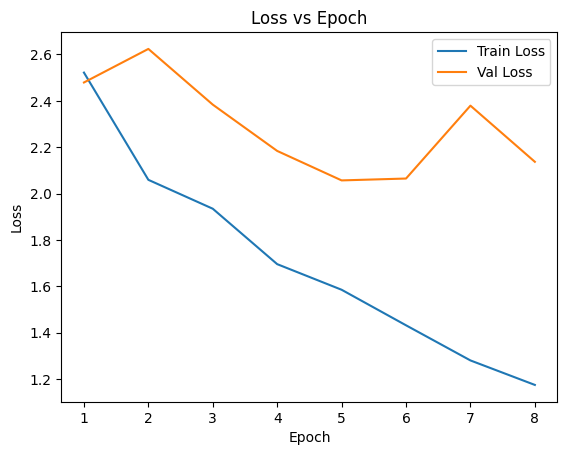

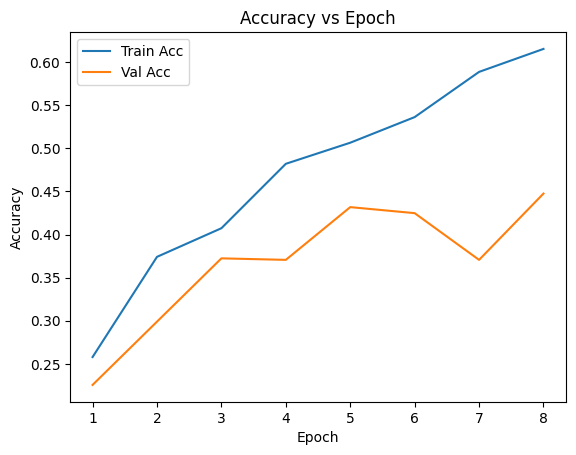


=== Classification Report (Validation Split) ===
                                    precision    recall  f1-score   support

                              acne     0.5000    0.1538    0.2353        26
                     acne-vulgaris     0.5536    0.6596    0.6019        47
                 actinic-keratosis     0.4286    0.1250    0.1935        24
              basal-cell-carcinoma     0.4933    0.5692    0.5286        65
  basal-cell-carcinoma-morpheiform     0.2800    0.7778    0.4118         9
                    dermatofibroma     0.2000    0.0909    0.1250        11
                   dermatomyositis     0.3269    0.8095    0.4658        21
                dyshidrotic-eczema     0.0000    0.0000    0.0000        12
                            eczema     0.2500    0.3214    0.2812        28
                   epidermal-nevus     0.5000    0.2308    0.3158        13
                      folliculitis     0.7895    0.3125    0.4478        48
                    kaposi-sarcoma   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x1000 with 0 Axes>

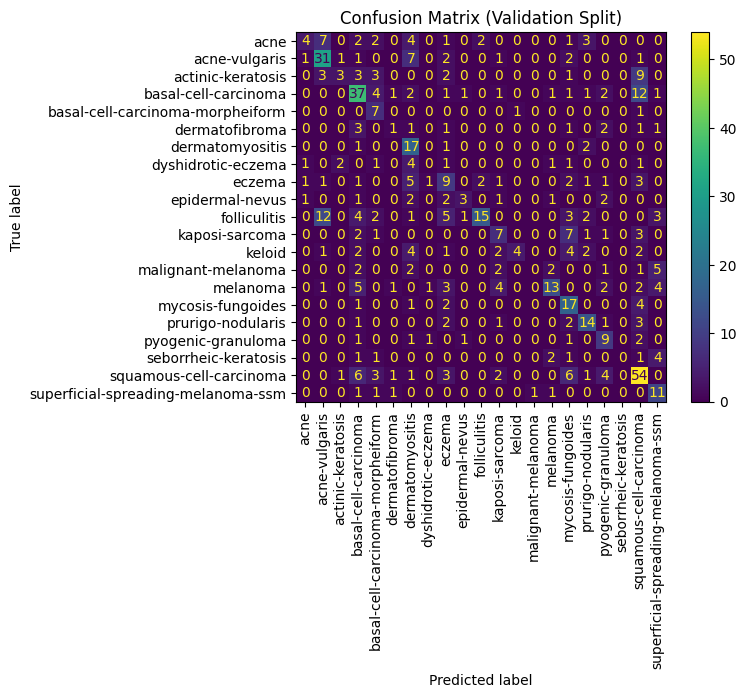

In [ ]:
# ============================================================
# learning curves + classification report + confusion matrix
# ============================================================

# Learning curves
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch")
plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch")
plt.legend(); plt.show()

# Load best weights for final reporting
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        preds = logits.argmax(dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

target_names = [inv_label_mapping[i] for i in range(num_classes)]

print("\n=== Classification Report (Validation Split) ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(10, 10))
disp.plot(values_format="d", xticks_rotation=90)
plt.title("Confusion Matrix (Validation Split)")
plt.show()


# train a small ensemble (EfficientNet + DenseNet)

In [ ]:
# ============================================================
#  train two more models for ensemble inference
# ============================================================

def build_model(model_name: str):
    if model_name == "resnet18":
        m = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        m = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    elif model_name == "densenet121":
        m = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
    else:
        raise ValueError(model_name)
    return m.to(device)

def train_model(model_name: str, save_path: str, epochs: int = num_epochs):
    m = build_model(model_name)
    opt = optim.Adam(m.parameters(), lr=1e-3)
    sch = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)

    best_acc = -1.0
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(m, train_loader, opt)
        va_loss, va_acc = evaluate(m, val_loader)
        sch.step(va_loss)

        print(f"[{model_name}] Epoch {ep:02d}/{epochs} | "
              f"Train loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"Val loss={va_loss:.4f} acc={va_acc:.4f}")

        if va_acc > best_acc:
            best_acc = va_acc
            torch.save(m.state_dict(), save_path)

    print(f"[{model_name}] best val acc={best_acc:.4f} saved={save_path}")
    return save_path

# Train & save
eff_path = "efficientnet_b0_best.pth"
den_path = "densenet121_best.pth"

_ = train_model("efficientnet_b0", eff_path, epochs=num_epochs)
_ = train_model("densenet121", den_path, epochs=num_epochs)


[efficientnet_b0] Epoch 01/8 | Train loss=2.2640 acc=0.3326 | Val loss=1.9218 acc=0.4056


[efficientnet_b0] Epoch 02/8 | Train loss=1.5106 acc=0.5345 | Val loss=1.7199 acc=0.4738


[efficientnet_b0] Epoch 03/8 | Train loss=1.1767 acc=0.6211 | Val loss=1.5941 acc=0.5367


[efficientnet_b0] Epoch 04/8 | Train loss=0.8729 acc=0.7212 | Val loss=2.0012 acc=0.5000


[efficientnet_b0] Epoch 05/8 | Train loss=0.7318 acc=0.7644 | Val loss=1.7605 acc=0.5192


[efficientnet_b0] Epoch 06/8 | Train loss=0.5260 acc=0.8252 | Val loss=1.7841 acc=0.5874


[efficientnet_b0] Epoch 07/8 | Train loss=0.2820 acc=0.9130 | Val loss=1.5135 acc=0.6084


[efficientnet_b0] Epoch 08/8 | Train loss=0.1707 acc=0.9458 | Val loss=1.5602 acc=0.6206
✅ [efficientnet_b0] best val acc=0.6206 saved=efficientnet_b0_best.pth
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 60.0MB/s]


[densenet121] Epoch 01/8 | Train loss=2.4401 acc=0.2784 | Val loss=2.2079 acc=0.3339


[densenet121] Epoch 02/8 | Train loss=1.9935 acc=0.3846 | Val loss=2.2633 acc=0.3217


[densenet121] Epoch 03/8 | Train loss=1.7792 acc=0.4423 | Val loss=1.9377 acc=0.4231


[densenet121] Epoch 04/8 | Train loss=1.5481 acc=0.5175 | Val loss=1.9048 acc=0.4161


[densenet121] Epoch 05/8 | Train loss=1.3839 acc=0.5542 | Val loss=1.7901 acc=0.4860


[densenet121] Epoch 06/8 | Train loss=1.2190 acc=0.6080 | Val loss=1.8773 acc=0.4808


[densenet121] Epoch 07/8 | Train loss=1.0768 acc=0.6604 | Val loss=2.1197 acc=0.4213


[densenet121] Epoch 08/8 | Train loss=1.0088 acc=0.6630 | Val loss=2.0222 acc=0.4441
✅ [densenet121] best val acc=0.4860 saved=densenet121_best.pth


# Test Dataset

In [ ]:
# ============================================================
# Inference: ensemble predictions on test set
# ============================================================

class TestDataset(Dataset):
    def __init__(self, df: pd.DataFrame, test_image_dir: str, transform=None):
        self.df = df.reset_index(drop=True)
        self.test_image_dir = test_image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        md5hash = self.df.iloc[idx]["md5hash"]
        image_path = os.path.join(self.test_image_dir, f"{md5hash}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Test image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, md5hash

test_dataset = TestDataset(df_test, test_image_dir=test_image_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Build and load models for ensemble:
# Always include ResNet18 best
model_names = ["resnet18"]
model_paths = {"resnet18": "resnet18_best.pth"}

# If trained the optional models above, include them automatically if files exist
if os.path.exists("efficientnet_b0_best.pth"):
    model_names.append("efficientnet_b0")
    model_paths["efficientnet_b0"] = "efficientnet_b0_best.pth"

if os.path.exists("densenet121_best.pth"):
    model_names.append("densenet121")
    model_paths["densenet121"] = "densenet121_best.pth"

print("Ensemble models:", model_names)

models_dict = {}
for name in model_names:
    m = build_model(name)
    m.load_state_dict(torch.load(model_paths[name], map_location=device))
    m.eval()
    models_dict[name] = m

@torch.no_grad()
def ensemble_predict(images):
    # Average logits across models
    logits = torch.stack([models_dict[name](images) for name in model_names]).mean(0)
    preds = logits.argmax(dim=1)
    return preds

predictions = []
for images, md5hashes in tqdm(test_loader, desc="Ensemble inference"):
    images = images.to(device, non_blocking=True)
    preds = ensemble_predict(images).cpu().numpy().tolist()

    for md5hash, pred_idx in zip(md5hashes, preds):
        predictions.append([md5hash, inv_label_mapping[int(pred_idx)]])

df_preds = pd.DataFrame(predictions, columns=["md5hash", "label"])
df_preds.to_csv("final_ensemble_predictions.csv", index=False)

print("Saved locally: final_ensemble_predictions.csv")
df_preds.head()


Ensemble models: ['resnet18', 'efficientnet_b0', 'densenet121']


Ensemble inference: 100%|██████████| 39/39 [02:31<00:00,  3.89s/it]

Saved locally: final_ensemble_predictions.csv


,md5hash,label
0,0844ae634f0e6e7ef1f73c2aeecbae0e,eczema
1,3b290d262098f761d719aa07cf36c040,basal-cell-carcinoma
2,cf561d08ac46d0fda678bff6621005ee,squamous-cell-carcinoma
3,e6371069be05c6b0a95b4b3f1bacc9a5,acne-vulgaris
4,f76cddb37265f97508f159078dcc7e7c,folliculitis


This prediction was submitted to a Kaggle competition hosted at MIT and our team secured 3rd place. The final F1 score was 0.71.

Competition Link: https://www.kaggle.com/competitions/bttai-ajl-2025/leaderboard